In [2]:
#!pip install cbor2

In [104]:
import os
import glob

import numpy as np
import cbor2

In [114]:
BASE_DIR = "data/jiuenfeng-project-1-export"  # 
TRAIN_DIR = os.path.join(BASE_DIR, "training")
TEST_DIR  = os.path.join(BASE_DIR, "testing")


In [115]:
def extract_features(values: np.ndarray) -> np.ndarray:
    """
    values: shape (T, 9) 的 IMU+角度数据
    返回: shape (75,) 的 float32 特征向量
    """
    v = values.astype(np.float32)
    T, D = v.shape
    assert D == 9, f"期望 9 维通道，实际 {D}"

    feats = []

    # 1) 全局 mean / std / min / max -> 9 * 4 = 36
    means = v.mean(axis=0)
    stds  = v.std(axis=0)
    mins  = v.min(axis=0)
    maxs  = v.max(axis=0)

    feats.extend(list(means))
    feats.extend(list(stds))
    feats.extend(list(mins))
    feats.extend(list(maxs))   # 这里累计 36 维

    # 2) 时间分三段，每段算 mean -> 3 * 9 = 27，累计 63 维
    segments = np.array_split(v, 3, axis=0)
    for seg in segments:
        seg_mean = seg.mean(axis=0)
        feats.extend(list(seg_mean))

    # 3) 每个通道的 energy（均方）-> 9 维，累计 72 维
    energy = (v ** 2).mean(axis=0)
    feats.extend(list(energy))

    # 4) 三个向量模长的 RMS（accel/gyro/angle 三组）-> 3 维，总计 75
    accel_mag = np.sqrt((v[:, 0:3] ** 2).sum(axis=1)).mean()  # ax,ay,az
    gyro_mag  = np.sqrt((v[:, 3:6] ** 2).sum(axis=1)).mean()  # gx,gy,gz
    ori_mag   = np.sqrt((v[:, 6:9] ** 2).sum(axis=1)).mean()  # roll,pitch,yaw

    feats.extend([accel_mag, gyro_mag, ori_mag])

    feats = np.array(feats, dtype=np.float32)
    assert feats.shape[0] == 75, feats.shape
    return feats


In [116]:
def load_split(split_dir):
    X_list = []
    label_name_list = []
    file_list = sorted(glob.glob(os.path.join(split_dir, "*.cbor")))
    print(f"{split_dir} 里找到 {len(file_list)} 个 .cbor 文件")

    for path in file_list:
        fname = os.path.basename(path)
        # 文件名前缀作为类别名，例如 "circle.xxx.cbor" -> "circle"
        label_name = fname.split(".")[0]
        if label_name == "noise":
            label_name = "other"

        with open(path, "rb") as f:
            msg = cbor2.load(f)

        payload = msg["payload"]
        values = np.array(payload["values"], dtype=np.float32)  # (T, 9)

        feats = extract_features(values)  # (75,)
        X_list.append(feats)
        label_name_list.append(label_name)

    X = np.stack(X_list, axis=0)                     # (N, 75)
    label_names = np.array(label_name_list)          # (N,)
    return X, label_names


In [117]:
X_trainval, label_names_trainval = load_split(TRAIN_DIR)
X_test,     label_names_test     = load_split(TEST_DIR)

print("trainval shape:", X_trainval.shape)
print("test shape:", X_test.shape)
print("trainval labels example:", np.unique(label_names_trainval))
print("test labels example:", np.unique(label_names_test))


data/jiuenfeng-project-1-export/training 里找到 187 个 .cbor 文件
data/jiuenfeng-project-1-export/testing 里找到 53 个 .cbor 文件
trainval shape: (187, 75)
test shape: (53, 75)
trainval labels example: ['circle' 'other' 'peak' 'wave']
test labels example: ['circle' 'other' 'peak' 'wave']


In [118]:
# 所有出现过的类别名
all_label_names = sorted(set(label_names_trainval.tolist() + 
                             label_names_test.tolist()))
label2id = {name: i for i, name in enumerate(all_label_names)}
id2label = {i: name for name, i in label2id.items()}

print("类别映射：")
for name, idx in label2id.items():
    print(f"  {idx} -> {name}")

classes_cnt = len(all_label_names)
print("classes_cnt =", classes_cnt)

# 映射到 int 标签
y_trainval = np.array([label2id[n] for n in label_names_trainval], dtype=np.int32)
y_test     = np.array([label2id[n] for n in label_names_test],     dtype=np.int32)


类别映射：
  0 -> circle
  1 -> other
  2 -> peak
  3 -> wave
classes_cnt = 4


In [119]:
rng = np.random.default_rng(seed=42)

N = len(X_trainval)
indices = np.arange(N)
rng.shuffle(indices)

X_trainval = X_trainval[indices]
y_trainval = y_trainval[indices]

train_cnt = int(0.8 * N)
val_cnt   = N - train_cnt

X_train = X_trainval[:train_cnt]
y_train = y_trainval[:train_cnt]
X_val   = X_trainval[train_cnt:]
y_val   = y_trainval[train_cnt:]

print("train_cnt      =", len(X_train))
print("validation_cnt =", len(X_val))
print("test_cnt       =", len(X_test))


train_cnt      = 149
validation_cnt = 38
test_cnt       = 53


In [120]:
def format_float_array(arr: np.ndarray, var_name: str) -> str:
    # 将 float 数组格式化为 C 语言的 float 数组
    vals = ", ".join(f"{v:.6f}f" for v in arr)
    return f"const float {var_name}[{len(arr)}] = {{ {vals} }};\\n"

def format_int_array(y: np.ndarray, var_name: str) -> str:
    vals = ", ".join(str(int(v)) for v in y)
    return f"const int {var_name}[{len(y)}] = {{ {vals} }};\n"

def format_2d_float_array(X: np.ndarray, var_name: str) -> str:
    n_samples, n_feats = X.shape
    lines = []
    lines.append(f"const float {var_name}[{n_samples}][{n_feats}] = {{")
    for row in X:
        row_str = ", ".join(f"{float(v):.6f}f" for v in row)
        lines.append(f"  {{ {row_str} }},")
    lines.append("};\n")
    return "\n".join(lines)


In [121]:
# --- 1. 计算归一化参数 (只基于训练集!) ---
# axis=0 表示沿着样本维度计算，得到每个特征(75维)的最小值和最大值
feature_min = X_train.min(axis=0)
feature_max = X_train.max(axis=0)

print("Min vector shape:", feature_min.shape)
print("Max vector shape:", feature_max.shape)
# 简单的检查，防止由静止数据导致的 max == min (除以0风险)
# 如果 max == min，我们在 max 上加一点点 epsilon
eps = 1e-6
same_val_indices = (feature_max - feature_min) < eps
if np.any(same_val_indices):
    print(f"注意: 有 {np.sum(same_val_indices)} 个特征是常量，已微调 max 值以避免除零。")
    feature_max[same_val_indices] += eps


# --- 2. 生成 data.h 内容 ---
first_layer_input_cnt = X_train.shape[1]

header_lines = []

header_lines.append("// Auto-generated data file for on-device training\n")
header_lines.append("#ifndef DATA_H")
header_lines.append("#define DATA_H\n")

header_lines.append(f"const int first_layer_input_cnt = {first_layer_input_cnt};")
header_lines.append(f"const int train_data_cnt        = {len(X_train)};")
header_lines.append(f"const int validation_data_cnt   = {len(X_val)};")
header_lines.append(f"const int test_data_cnt         = {len(X_test)};")
header_lines.append(f"const int classes_cnt           = {classes_cnt};\n")

header_lines.append("// Label mapping:")
for idx in range(classes_cnt):
    header_lines.append(f"//   {idx} -> {id2label[idx]}")
header_lines.append("")

# --- 新增: 写入归一化参数 ---
header_lines.append("// Normalization parameters (Min-Max from Training Set)")
header_lines.append(format_float_array(feature_min, "feature_min"))
header_lines.append(format_float_array(feature_max, "feature_max"))
header_lines.append("")

# 标签数组
header_lines.append(format_int_array(y_train, "train_labels"))
header_lines.append(format_int_array(y_val, "validation_labels"))
header_lines.append(format_int_array(y_test, "test_labels"))

# 特征数据数组 (保持原始数据 RAW，让板子去归一化，或者你也可以在这里预处理好)
# 建议: 保持 RAW 数据导出，让板子用 feature_min/max 归一化 input buffer
# 这样板子在 Inference 时逻辑是一样的 (Raw Sensor -> Normalize -> Predict)
header_lines.append(format_2d_float_array(X_train, "train_data"))
header_lines.append(format_2d_float_array(X_val,   "validation_data"))
header_lines.append(format_2d_float_array(X_test,  "test_data"))

header_lines.append("#endif // DATA_H\n")

data_h_text = "\n".join(header_lines)

with open("data/data_fje_maxmin_norm.h", "w") as f:
    f.write(data_h_text)

print("✅ 已生成 data.h (包含 feature_min 和 feature_max)")

Min vector shape: (75,)
Max vector shape: (75,)
✅ 已生成 data.h (包含 feature_min 和 feature_max)


In [122]:
# =========================
# 在 Python 里用的训练数据
# =========================

def normalize_with_minmax(X, fmin, fmax, eps=1e-6):
    # 和板子上一样的 Min-Max 归一化
    return (X - fmin) / (fmax - fmin + eps)

X_train_norm = normalize_with_minmax(X_train, feature_min, feature_max)
X_val_norm   = normalize_with_minmax(X_val,   feature_min, feature_max)
X_test_norm  = normalize_with_minmax(X_test,  feature_min, feature_max)

print("X_train_norm shape:", X_train_norm.shape)
print("X_val_norm   shape:", X_val_norm.shape)
print("X_test_norm  shape:", X_test_norm.shape)


X_train_norm shape: (149, 75)
X_val_norm   shape: (38, 75)
X_test_norm  shape: (53, 75)


In [123]:
BASE_DIR = os.getcwd()   # 或者直接写成固定路径也行

save_dir = os.path.join(BASE_DIR, "PC_training", "data")
os.makedirs(save_dir, exist_ok=True)


np.savez(
    os.path.join(save_dir, "fje_imu_75feat_minmax_norm.npz"),
    X_train=X_train_norm,
    y_train=y_train,
    X_val=X_val_norm,
    y_val=y_val,
    X_test=X_test_norm,
    y_test=y_test,
    feature_min=feature_min,
    feature_max=feature_max,
)

Picked classes: ['circle', 'other', 'peak', 'wave']


/tmp/ipykernel_21056/2906952882.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


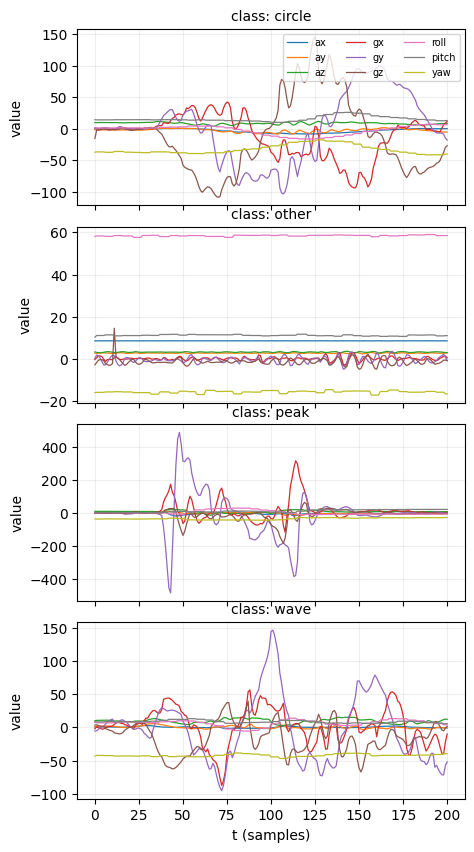

Saved: Slides/figures/raw_cbor_example.png


In [124]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

OUT_DIR = "Slides/figures"
os.makedirs(OUT_DIR, exist_ok=True)

# 收集每个类别对应的 .cbor 文件
paths_by_class = defaultdict(list)
for path in sorted(glob.glob(os.path.join(TRAIN_DIR, "*.cbor"))):
    label = os.path.basename(path).split(".")[0]
    if label == "noise":
        label = "other"
    paths_by_class[label].append(path)

all_classes = sorted(paths_by_class.keys())
picked_classes = all_classes[:4]  # 或手动指定：["circle","up","down","other"]
print("Picked classes:", picked_classes)

rng = np.random.default_rng(0)

def load_values_from_cbor(path):
    with open(path, "rb") as f:
        msg = cbor2.load(f)
    return np.array(msg["payload"]["values"], dtype=np.float32)  # (T, 9)

channel_names = ["ax","ay","az","gx","gy","gz","roll","pitch","yaw"]

# 4x1 subplot
fig, axes = plt.subplots(
    4, 1,
    figsize=(5, 10),            # ← 宽度变窄（原来14），高度保持细长
    sharex=True,
    gridspec_kw={"hspace": 0.12} # ← 子图间距更小
)

for i in range(4):
    ax = axes[i]
    if i >= len(picked_classes):
        ax.axis("off")
        continue

    cls = picked_classes[i]
    if len(paths_by_class[cls]) == 0:
        ax.set_title(f"class: {cls} (no samples)")
        ax.axis("off")
        continue

    sample_path = rng.choice(paths_by_class[cls])
    v = load_values_from_cbor(sample_path)  # (T, 9)
    t = np.arange(v.shape[0])

    for ch in range(9):
        ax.plot(t, v[:, ch], linewidth=0.9)

    ax.set_title(f"class: {cls}", fontsize=10)
    ax.set_ylabel("value")
    ax.grid(True, alpha=0.2)

axes[-1].set_xlabel("t (samples)")

# legend 放第一行，且更紧凑
axes[0].legend(channel_names, loc="upper right", fontsize=7, ncol=3, frameon=True)

fig.tight_layout()
out_path = os.path.join(OUT_DIR, "raw_cbor_example.png")
fig.savefig(out_path, dpi=300, bbox_inches="tight")
plt.show()
plt.close(fig)

print("Saved:", out_path)
